# As at Date demonstration Example

This notebook will demonstrate how the As At date can be used to get data from different system dates.

An asset manager has a portfolio into which they load daily transactions for a week, including a Corporate Action Dividend. Towards the end of the week, two corrections were made to the transaction posted on Day 1. At the end of the week they want to generate holdings for each day, calculated before and after each correction was made.

## Load transactions
- Day 1 :
Load transactions
- Day 2 :
Load Dividend corporate action and Funds In
- Day 3 :
nothing logged
- Day 4 :
Load in more transactions, including a correction to the trade on Day 1, and a transaction that occured on Day 3
- Day 5 : 
Correct another transaction for Day 1

### Get holdings of Day 1 calculated each day of the week
The asset manager can track how the holdings on Day 1 changed throughout the week as corrections were made by calling the `get holdings` endpoint with effective date `Day 1` and As At dates on the following days

|   | As-At: 1  |  As-At: 2 |  As-At: 3 | As-At: 4  | As-At: 5  |
|---|---|---|---|---|---|
| Eff: 1  |  hld | hld | hld | hld | hld |

### Get holdings for each day, calculated any day of the week
The same approach can be used to get analyse corrections made for every other day of the week.

|   | As-At: 1  |  As-At: 2 |  As-At: 3 | As-At: 4  | As-At: 5  |
|---|---|---|---|---|---|
| Eff: 1  |  hld | hld | hld | hld | hld |
|  Eff: 2 |  - |  hld | hld | hld | hld |
|  Eff: 3 |  - |  - |  hld | hld | hld |
|  Eff: 4 | -  | -  | -  | hld  | hld |
|  Eff: 5 | -  | -  | -  |  - | hld  |



Firstly we begin by importing the modules we will be using. This tutorial will use `lusidtools`, a package that contains utility functions for preparing and uploading data using the lusid-python-sdk.

In [33]:
import os
import lusid
import copy
import matplotlib.pyplot as plt
from lusidtools.cocoon import load_from_data_frame
from lusidtools.cocoon.utilities import create_scope_id, identify_cash_items
from lusid.utilities import ApiClientFactory
from lusidtools.cocoon.transaction_type_upload import (
    create_transaction_type_configuration,
)
from lusidtools.cocoon.dateorcutlabel import DateOrCutLabel
from lusidjam import RefreshingToken
import pandas as pd
from lusidtools.cocoon.cocoon_printer import (
    format_instruments_response,
    format_portfolios_response,
    format_transactions_response,
    format_quotes_response
)

# Authenticate our user and create our API client
secrets_path = os.getenv("FBN_SECRETS_PATH")

api_factory = lusid.utilities.ApiClientFactory(
    token=RefreshingToken(),
    api_secrets_filename = secrets_path,
    app_name="LusidJupyterNotebook")

print('LUSID Environment Initialised')
print('LUSID version : ', api_factory.build(lusid.api.ApplicationMetadataApi).get_lusid_versions().build_version)

# Define our scope and portfolio code
scope = "As_at_DEMO-"+ create_scope_id()
code = "PORT_0001"
print(f"Scope: {scope}")
print(f"Code: {code}")

LUSID Environment Initialised
LUSID version :  0.5.4238.0
Scope: As_at_DEMO-3857-d424-4ea5-9e
Code: PORT_0001


## Load Transaction data for each day

In [34]:
days = ["Day1", "Day2", "Day3", "Day4", "Day5"]

convert = {
    'txn_date': str,
    'settle_date': str,
}

# Load Data for each day
txn_data_1 = pd.read_excel("./data/as-at-POC-txns.xlsx", sheet_name=days[0], converters=convert)
txn_data_2 = pd.read_excel("./data/as-at-POC-txns.xlsx", sheet_name=days[1], converters=convert)
txn_data_3 = pd.read_excel("./data/as-at-POC-txns.xlsx", sheet_name=days[2], converters=convert)
txn_data_4 = pd.read_excel("./data/as-at-POC-txns.xlsx", sheet_name=days[3], converters=convert)
txn_data_5 = pd.read_excel("./data/as-at-POC-txns.xlsx", sheet_name=days[4], converters=convert)


This dictionary maps the required LUSID fields to the columns in the data files

In [35]:
mapping = {
    "instruments" : {
        "identifier_mapping": {
            "ClientInternal": "Internal_id",
        },
        "required": {
            "name": "instr_id"
        },
    },
    "portfolios": {
        "required": {
            "code": "Portfolio",
            "display_name":  "$As-at_POC",
            "base_currency": "$GBP",
            "created": "$2018-01-01T00:00:00+00:00"
        },
    },
    "transactions": {
        "identifier_mapping" : {
            "ClientInternal" : "Internal_id",
            "Name" : "instr_id"
        },
        "required" : {
            "code": "Portfolio",
            "transaction_id": "txn_id",
            "type": "type",
            "transaction_price.price": "price",
            "transaction_price.type": "$Price",                   # example of literal values
            "total_consideration.amount": "amount",
            "units": "units",
            "transaction_date": "txn_date",
            "transaction_currency": "trade_currency",
            "total_consideration.currency": "trade_currency",
            "settlement_date": "settle_date"
        },
        "properties": [
            "description"
        ]
    },
    "cash_flag": {
        "cash_identifiers": {
            "Internal_id" : ["GBP"]
        },
        "implicit": "trade_currency"
    }
}

# Load Instrument master

We will begin by uploading our instruments to LUSID from our security master. Once uploaded, LUSID will attempt to resonve any transactions or holdings against this. Any new instruments that cannot be resolved will be given a sudo ID until the updated security master is loaded, at which point any unresolved instruments will be updated.

We have enough detail in the transaction file to populate a security master, so the inital instruments will be upserted using the transaction file as the source data.


In [36]:
# Data to be used to populate instrument master
txn_data_4.drop_duplicates(subset=[mapping["instruments"]["identifier_mapping"]["ClientInternal"]])

,Portfolio,txn_id,txn_date,settle_date,units,price,amount,trade_currency,instr_id,Internal_id,type,description
0,PORT_0001,txn_0001,2020-03-01,2020-03-01,80,20,2000,GBP,AVIVA,ID_aa001,StockIn,NaN
2,PORT_0001,txn_0003,2020-03-03,2020-03-03,100,50,2000,GBP,VOD,ID_aa002,Buy,NaN
3,PORT_0001,txn_0004,2020-03-04,2020-03-04,100,80,2000,GBP,BP,ID_aa003,Buy,NaN


In [37]:
# Call LUSID to upsert instruments
response = load_from_data_frame(
        api_factory=api_factory,
        scope=scope,
        data_frame=copy.deepcopy(txn_data_4.drop_duplicates(subset=[mapping["instruments"]["identifier_mapping"]["ClientInternal"]])),
        mapping_required=mapping["instruments"]["required"],
        file_type="instruments",
        mapping_optional={},
        identifier_mapping=mapping["instruments"]["identifier_mapping"]
)

# format response object
success, failed, errors = format_instruments_response(response)
print(f"Successes: {len(success)}")
print(f"Failed   : {len(failed)}")
print(f"Errors   : {len(errors)}")
success

Successes: 3
Failed   : 0
Errors   : 0


,successful items
0,NaN
1,NaN
2,NaN


## Create Portfolio

Next we will create a portfolio in LUSID into which we will upsert transactions. At this point the the `set holdings` API endpoint could be used specify the positions on the day at which our portfolio begins.

In [38]:
# call LUSID to create a portfolio or update details of an existing portfolio
response = load_from_data_frame(
        api_factory=api_factory,
        scope=scope,
        data_frame=copy.deepcopy(txn_data_1),
        mapping_required=mapping["portfolios"]["required"],
        file_type="portfolios",
        mapping_optional={},
)

# format response object
success, errors = format_portfolios_response(response)
print(f"Successes: {len(success)}")
print(f"Errors   : {len(errors)}")
success

Successes: 1
Errors   : 0


,successful items
0,PORT_0001


# Upsert transactions

With a portfolio created in LUSID, We can now begin to upsert transactions on a daily basis.

## Day 1

Load transactions with settlement date of T-2

Today one trade was made, 100 units of AVIVA. The details are upserted to LUSID using the following code.

In [39]:
# Day 1 transactions
txn_data_1

,Portfolio,txn_id,txn_date,settle_date,units,price,amount,trade_currency,instr_id,Internal_id,type,description
0,PORT_0001,txn_0001,2020-03-01,2020-03-01,100,20,2000,GBP,AVIVA,ID_aa001,StockIn,NaN


In [40]:
# call LUSID to upsert transactions
response = load_from_data_frame(
        api_factory=api_factory,
        scope=scope,
        data_frame=txn_data_1,
        mapping_required=mapping["transactions"]["required"],
        file_type="transactions",
        mapping_optional={},
        identifier_mapping=mapping["transactions"]["identifier_mapping"]
)

# format response object
success, errors = format_transactions_response(response)
print(f"Successes: {len(success)}")
print(f"Errors   : {len(errors)}")


# Store the date at which these transactions were set
if len(errors) == 0:
    Day1_as_at_date = response["transactions"]["success"][0].version.as_at_date
    print(f"Day1 As At Date: {str(Day1_as_at_date)}")

Successes: 1
Errors   : 0
Day1 As At Date: 2020-04-03 12:25:45.041131+00:00


## Day 2
Add funds and upload Dividend as a transaction

Today Funds were put into the account and a dividend was issued for AVIVA which in this case is represented as a transaction.

In [41]:
# Day 2 transactions
txn_data_2

,Portfolio,txn_id,txn_date,settle_date,units,price,amount,trade_currency,instr_id,Internal_id,type,description
0,PORT_0001,DIV_0001,2020-03-02,2020-03-02,200,1,200,GBP,GBP,ID_aa001,DividendCash,Dividend for AVIVA shareholders
1,PORT_0001,CASHIN_001,2020-03-02,2020-03-02,10000,1,10000,GBP,GBP,GBP,FundsIn,Adding Cash to portfolio


In [42]:
CA_as_transactions, CA_mapping = identify_cash_items(copy.deepcopy(txn_data_2), copy.deepcopy(mapping), "transactions", False)

response = load_from_data_frame(
        api_factory=api_factory,
        scope=scope,
        data_frame=CA_as_transactions,
        mapping_required=CA_mapping["transactions"]["required"],
        file_type="transactions",
        mapping_optional={},
        identifier_mapping=CA_mapping["transactions"]["identifier_mapping"]
)

success, errors = format_transactions_response(response)
print(f"Successes: {len(success)}")
print(f"Errors   : {len(errors)}")

# Store the date at which these transactions were set
if len(errors) == 0:
    Day2_as_at_date = response["transactions"]["success"][0].version.as_at_date
    print(f"Day2 As At Date: {str(Day2_as_at_date)}")

Successes: 1
Errors   : 0
Day2 As At Date: 2020-04-03 12:25:46.403477+00:00


## Day 3

No trades or adjustments were recorded this day

In [43]:
# Day 3 transactions
txn_data_3

,Portfolio,txn_id,txn_date,settle_date,units,price,amount,trade_currency,instr_id,Internal_id,type


## Day 4
Load in more transactions including a correction to Day 1's transaction and a Trade that occured on Day 3

In [44]:
# Day 4 transactions
txn_data_4

,Portfolio,txn_id,txn_date,settle_date,units,price,amount,trade_currency,instr_id,Internal_id,type,description
0,PORT_0001,txn_0001,2020-03-01,2020-03-01,80,20,2000,GBP,AVIVA,ID_aa001,StockIn,NaN
1,PORT_0001,txn_0002,2020-03-04,2020-03-04,100,20,2000,GBP,AVIVA,ID_aa001,Buy,NaN
2,PORT_0001,txn_0003,2020-03-03,2020-03-03,100,50,2000,GBP,VOD,ID_aa002,Buy,NaN
3,PORT_0001,txn_0004,2020-03-04,2020-03-04,100,80,2000,GBP,BP,ID_aa003,Buy,NaN


In [45]:
response = load_from_data_frame(
        api_factory=api_factory,
        scope=scope,
        data_frame=txn_data_4,
        mapping_required=mapping["transactions"]["required"],
        file_type="transactions",
        mapping_optional={},
        identifier_mapping=mapping["transactions"]["identifier_mapping"]
)

success, errors = format_transactions_response(response)
print(f"Successes: {len(success)}")
print(f"Errors   : {len(errors)}")

# Store the date at which these transactions were set
if len(errors) == 0:
    Day4_as_at_date = response["transactions"]["success"][0].version.as_at_date
    print(f"Day4 As At Date: {str(Day4_as_at_date)}")
    
success

Successes: 1
Errors   : 0
Day4 As At Date: 2020-04-03 12:25:47.127203+00:00


,successful items
0,PORT_0001


## Day 5
Make another correction to Day 1's transaction

In [46]:
# Day 5 transactions
txn_data_5

,Portfolio,txn_id,txn_date,settle_date,units,price,amount,trade_currency,instr_id,Internal_id,type,description
0,PORT_0001,txn_0001,2020-03-01,2020-03-01,120,25,3000,GBP,AVIVA,ID_aa001,StockIn,NaN


In [47]:
response = load_from_data_frame(
        api_factory=api_factory,
        scope=scope,
        data_frame=txn_data_5,
        mapping_required=mapping["transactions"]["required"],
        file_type="transactions",
        mapping_optional={},
        identifier_mapping=mapping["transactions"]["identifier_mapping"]
)

success, errors = format_transactions_response(response)
print(f"Successes: {len(success)}")
print(f"Errors   : {len(errors)}")

# Store the date at which these transactions were set
if len(errors) == 0:
    Day5_as_at_date = response["transactions"]["success"][0].version.as_at_date
    print(f"Day1 As At Date: {str(Day5_as_at_date)}")

Successes: 1
Errors   : 0
Day1 As At Date: 2020-04-03 12:25:47.763143+00:00


# Get holdings

Get holdings day 1 --> 5

While `StockIn` is a default transaction type for LUSID, `DividendCash`is a custom transaction type and we need to configure before getting holdings, in order for LUSID to understand how to interpret the underlying movements. See the support article on [configuring transaction types](https://support.finbourne.com/configuring-transaction-types) for more datail on this.

In [48]:
# Create a custom transaction type for cash dividends
create_transaction_type_configuration(
    api_factory,
    alias=lusid.models.TransactionConfigurationTypeAlias(
        type="DividendCash",
        description="A cash payments from dividends",
        transaction_class="EquityInstruments",
        transaction_group="default",
        transaction_roles="LongLonger",
    ),
    movements=[
        lusid.models.TransactionConfigurationMovementDataRequest(
            movement_types="CashCommitment",
            side="Side2",
            direction=1,
            properties=None,
            mappings=None,
        )
    ],
)

{'links': [{'description': None,
            'href': 'https://tobytest-3.lusid.com/api/api/schemas/entities/TransactionConfigurationData',
            'method': 'GET',
            'relation': 'EntitySchema'},
           {'description': None,
            'href': 'https://tobytest-3.lusid.com/api/',
            'method': 'GET',
            'relation': 'PropertySchema'},
           {'description': 'Request ID',
            'href': 'http://tobytest-3.lusid.com/app/insights/logs/0HLUNNQNLUN1C:00000003',
            'method': 'POST',
            'relation': 'RequestLogs'}],
 'side_definitions': [{'amount': 'Txn:TradeAmount',
                       'currency': 'Txn:TradeCurrency',
                       'links': None,
                       'rate': 'Txn:TradeToPortfolioRate',
                       'security': 'Txn:LusidInstrumentId',
                       'side': 'Side1',
                       'units': 'Txn:Units'},
                      {'amount': 'Txn:TotalConsideration',
               

Here we collect specify the as at dates we are going to calculate holdings using

In [49]:
from datetime import timedelta
asat_dates = [
    Day1_as_at_date,                                # Day 1
    Day2_as_at_date,                                # Day 2
    Day4_as_at_date - timedelta(microseconds=1),    # Day 3
    Day4_as_at_date,                                # Day 4
    Day5_as_at_date,                                # Day 5
]

In [50]:
# gets holdings for an effective date, calculated As At a list of days 
def get_holdings(api_factory, asat_dates, scope, code, effective_at):
    daily_report=[]
    n=1
    for i in asat_dates:
        data={}
        response = api_factory.build(lusid.api.TransactionPortfoliosApi).get_holdings(
            scope=scope,
            code=code,
            effective_at=effective_at,
            as_at=i.isoformat(),
            property_keys=["Instrument/default/Name"]
        )

        summary = display_holdings_summary(response)

        n=n+1
        daily_report.append(summary)
    return daily_report

In [51]:
# Prints the name and a quick summary from a get_holdings() response 
def display_holdings_summary(response):
    # inspect holdings response for today
    hld = [i for i in response.values]
    
    names=[]
    amount=[]
    units=[]
    shks=[]
    
    for item in hld:
        
        names.append(item.properties['Instrument/default/Name'].value.label_value)
        amount.append(item.cost.amount)
        units.append(item.units)
        shks.append([item.sub_holding_keys[key].value.label_value for key in item.sub_holding_keys.keys()])
        
    data={
        "names" : names,
        "amount" : amount,
        "units" : units,
        "shks" : shks
    }
    
    summary = pd.DataFrame(data=data)
    return summary

In [52]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table'),raw=True)

Now that all of the transactions (including corrections) have been loading into LUSID, the asset manager wants to vuew how the holdings on Day 1 changed throughout the week.

In other words we are getting holdings effective at Day 1, calculated as at Days 1 to 5.

## Effective Day 1

On Day 1, AVIVA stock was put into the portfolio (which was amended on Days 4 & 5)


Holdings for Day 1
------------------
Calculated as at Day1, Day2, Day3, Day4, Day5


,names,amount,units,shks
0,AVIVA,2000.0,100.0,[]
,names,amount,units,shks
0,AVIVA,2000.0,100.0,[]
,names,amount,units,shks
0,AVIVA,2000.0,100.0,[]
,names,amount,units,shks
0,AVIVA,2000.0,80.0,[]
,names,amount,units,shks
0,AVIVA,3000.0,120.0,[]


Text(0, 0.5, 'Units of AVIVA')

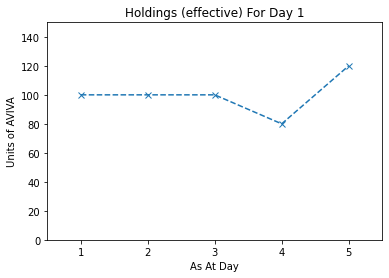

In [53]:
# Get Day 1's holdings, calculated on days 1 to 5 
daily_report = get_holdings(api_factory, asat_dates, scope, code, "2020-03-01T00:00:00.000000+00:00")

print(f"\nHoldings for Day 1")
print(f"------------------") 
print(f"Calculated as at Day1, Day2, Day3, Day4, Day5")

display_side_by_side(daily_report[0], daily_report[1], daily_report[2], daily_report[3], daily_report[4])

# Visualize the corrections made to AVIVA throughout the week
y = [i["units"] for i in daily_report]
plt.plot([1, 2, 3, 4, 5], y, "--x")
plt.xlabel("As At Day")
plt.title("Holdings (effective) For Day 1")
plt.axis([0.5, 5.5, 0, 150])
plt.ylabel("Units of AVIVA")

## Effective Day 2


On Day 2, A dividend was paid into the account of 200 GBP. In addition 10000 of GBP Funds were added to the account 

In [54]:
# Get Day 2's holdings, calculated on days 1 to 5
print(f"\nHoldings for Day 2")
print(f"------------------") 
print(f"Calculated as at Day2, Day3, Day4, Day5")

daily_report = get_holdings(api_factory, asat_dates[1:], scope, code, "2020-03-02T00:00:00.000000+00:00")

display_side_by_side(daily_report[0], daily_report[1], daily_report[2], daily_report[3])


Holdings for Day 2
------------------
Calculated as at Day2, Day3, Day4, Day5


,names,amount,units,shks
0,AVIVA,2000.0,100.0,[]
1,CCY_GBP,10200.0,10200.0,[]
,names,amount,units,shks
0,AVIVA,2000.0,100.0,[]
1,CCY_GBP,10200.0,10200.0,[]
,names,amount,units,shks
0,AVIVA,2000.0,80.0,[]
1,CCY_GBP,10200.0,10200.0,[]
,names,amount,units,shks
0,AVIVA,3000.0,120.0,[]


## Effective Day 3

One trade in VOD occoured on day 3 (but not logged until Day 4)

In [55]:
# Get Day 3's holdings, calculated on days 1 to 5
print(f"\nHoldings for Day 2")
print(f"------------------")
print(f"Calculated as at Day3, Day4, Day5")

daily_report = get_holdings(api_factory, asat_dates[2:], scope, code, "2020-03-03T00:00:00.000000+00:00")

display_side_by_side(daily_report[0], daily_report[1], daily_report[2])


Holdings for Day 2
------------------
Calculated as at Day3, Day4, Day5


,names,amount,units,shks
0,AVIVA,2000.0,100.0,[]
1,CCY_GBP,10200.0,10200.0,[]
,names,amount,units,shks
0,AVIVA,2000.0,80.0,[]
1,VOD,2000.0,100.0,[]
2,CCY_GBP,8200.0,8200.0,[]
,names,amount,units,shks
0,AVIVA,3000.0,120.0,[]
1,VOD,2000.0,100.0,[]
2,CCY_GBP,8200.0,8200.0,[]


## Effective Day 4

On day 4 Two trades were made in AVIVA and BP.

In [56]:
# Get Day 4's holdings, calculated on days 1 to 5
print(f"\nHoldings for Day 4")
print(f"------------------") 
daily_report = get_holdings(api_factory, asat_dates[3:], scope, code, "2020-03-04T00:00:00.000000+00:00")

display_side_by_side(daily_report[0], daily_report[1])


Holdings for Day 4
------------------


,names,amount,units,shks
0,AVIVA,4000.0,180.0,[]
1,VOD,2000.0,100.0,[]
2,BP,2000.0,100.0,[]
3,CCY_GBP,4200.0,4200.0,[]
,names,amount,units,shks
0,AVIVA,5000.0,220.0,[]
1,VOD,2000.0,100.0,[]
2,BP,2000.0,100.0,[]
3,CCY_GBP,4200.0,4200.0,[]


## Effective Day 5

On Day 5 no new trandactions occoured. 

In [57]:
# Get Day 5's holdings, calculated on days 1 to 5
print(f"\nHoldings for Day 5")
print(f"------------------") 
print(f"Calculated as at Day1, Day2, Day3, Day4, Day5")

daily_report = get_holdings(api_factory, asat_dates[4:], scope, code, "2020-03-05T00:00:00.000000+00:00")

display_side_by_side(daily_report[0])


Holdings for Day 5
------------------
Calculated as at Day1, Day2, Day3, Day4, Day5


,names,amount,units,shks
0,AVIVA,5000.0,220.0,[]
1,VOD,2000.0,100.0,[]
2,BP,2000.0,100.0,[]
3,CCY_GBP,4200.0,4200.0,[]
